In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("wallet_dataset.csv")

In [4]:
feature_cols = [
    'tx_count',
    'active_days',
    'avg_tx_per_day',
    'total_gas_spent',
    'total_nft_buys',
    'total_nft_sells',
    'total_nft_volume_usd',
    'unique_nfts_owned',
    'dex_trades',
    'avg_trade_size_usd',
    'total_traded_usd',
    'erc20_receive_usd',
    'erc20_send_usd',
    'native_balance_delta'
]

X = df[feature_cols].copy()

In [5]:
try:
    pt = joblib.load("wallet_power_transformer.pkl")
    X_scaled_np = pt.transform(X)
except:
    print("PowerTransformer model not found. Rerunning transformation...")
    from sklearn.preprocessing import PowerTransformer
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    X_scaled_np = pt.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled_np, columns=X.columns)

results = {}

X_scaled.shape

(1221, 14)

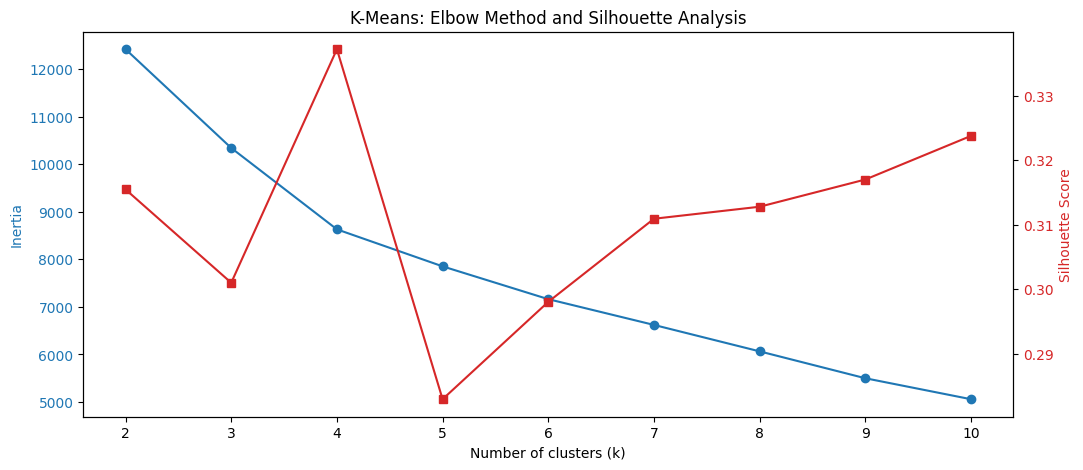

In [6]:
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)    
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.plot(K_range, inertia, marker='o', color='tab:blue', label = "Inetia")
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:red')
ax2.plot(K_range, silhouette_scores, marker='s', color='tab:red', label = "Silhouette")
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("K-Means: Elbow Method and Silhouette Analysis")
plt.show()

In [7]:
best_k = K_range[np.argmax(silhouette_scores)]
best_k

4

In [8]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(X_scaled)
labels_kmeans

array([3, 3, 3, ..., 0, 2, 0], shape=(1221,), dtype=int32)

In [9]:
results['K-Means'] = {
    "Silhouette" : silhouette_score(X_scaled, labels_kmeans),
    "Davies-Bouldin" : davies_bouldin_score(X_scaled, labels_kmeans),
    "Calinski-Harabasz" : calinski_harabasz_score(X_scaled, labels_kmeans),
    "Labels" : labels_kmeans
 }

In [10]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

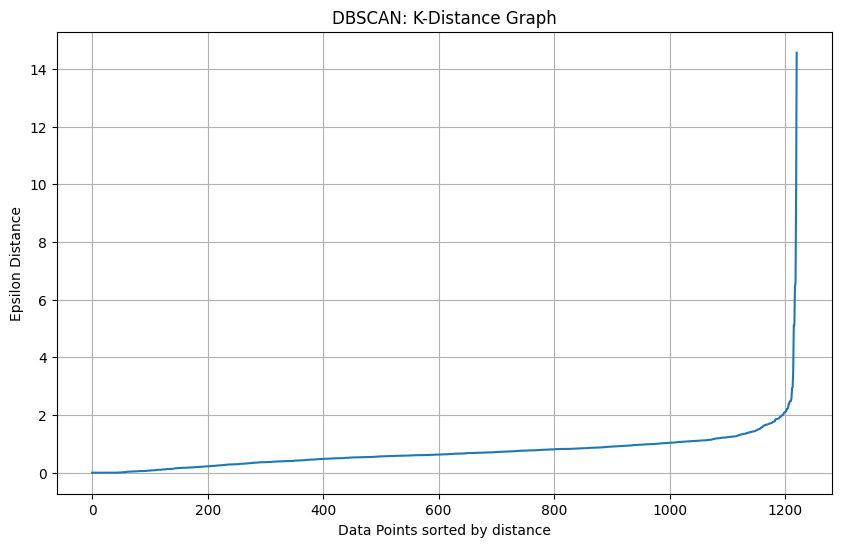

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title("DBSCAN: K-Distance Graph")
plt.ylabel("Epsilon Distance")
plt.xlabel("Data Points sorted by distance")
plt.grid()
plt.show()

In [12]:
eps_guess = 0.5
min_samples_guess = 5

dbscan = DBSCAN(eps=eps_guess, min_samples=min_samples_guess)
labels_dbscan = dbscan.fit_predict(X_scaled)

n_cluster_db = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_db = list(labels_dbscan).count(-1)

n_cluster_db, n_noise_db

(11, 942)

In [13]:
if n_cluster_db > 1:
    results['DBSCAN'] = {
        "Silhouette" : silhouette_score(X_scaled, labels_dbscan),
        "Davies-Bouldin" : davies_bouldin_score(X_scaled, labels_dbscan),
        "Calinski-Harabasz" : calinski_harabasz_score(X_scaled, labels_dbscan),
        "Labels" : labels_dbscan
     }
else:
    print("DBSCAN did not find more than 1 cluster. Skipping metric calculations.")
    results['DBSCAN'] = {"Silhouette" : -1, "Davies-Bouldin" : 999, "Calinski-Harabasz" : 0, "Labels" : labels_dbscan}

In [14]:
bic_scores = []
aic_scores = []
n_components_range = range(2, 11)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42, n_init= 1)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

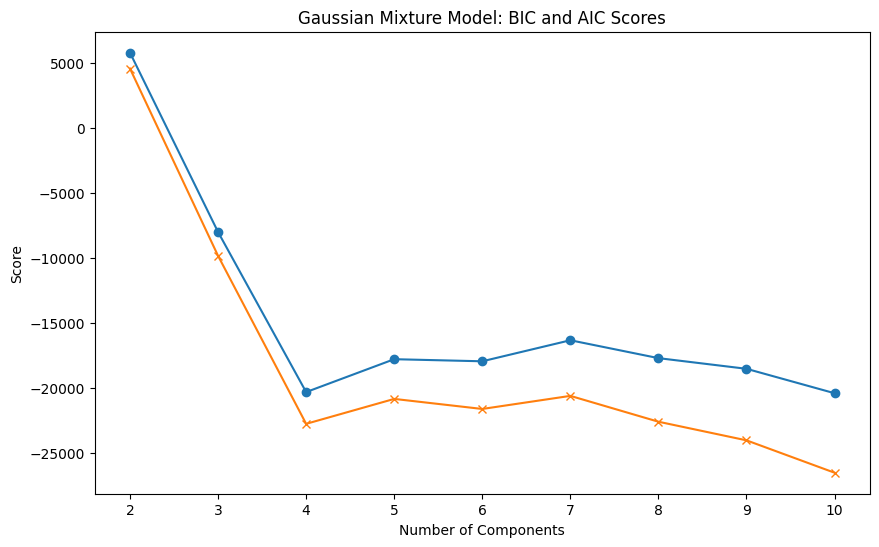

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
plt.plot(n_components_range, aic_scores, marker='x', label='AIC')
plt.legend
plt.title("Gaussian Mixture Model: BIC and AIC Scores")
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.show()

In [16]:
best_n_gmm = n_components_range[np.argmin(bic_scores)]
best_n_gmm

10

In [17]:
gmm_final = GaussianMixture(n_components=best_n_gmm, random_state=42)
labels_gmm = gmm_final.fit_predict(X_scaled)
results['GMM'] = {
    "Silhouette" : silhouette_score(X_scaled, labels_gmm),
    "Davies-Bouldin" : davies_bouldin_score(X_scaled, labels_gmm),
    "Calinski-Harabasz" : calinski_harabasz_score(X_scaled, labels_gmm),
    "Labels" : labels_gmm
 }


In [18]:
comparison_df = pd.DataFrame(results).T[["Silhouette", "Davies-Bouldin", "Calinski-Harabasz"]]

comparison_df = comparison_df.sort_values(by="Silhouette", ascending=False)
comparison_df

,Silhouette,Davies-Bouldin,Calinski-Harabasz
K-Means,0.337239,1.17525,397.824832
GMM,0.193407,1.536489,210.096629
DBSCAN,-0.174727,0.974906,41.523783


In [19]:
best_model_name = comparison_df.index[0]
best_model_name

'K-Means'

In [20]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_jobs=-1)
tsne_results = tsne.fit_transform(X_scaled)

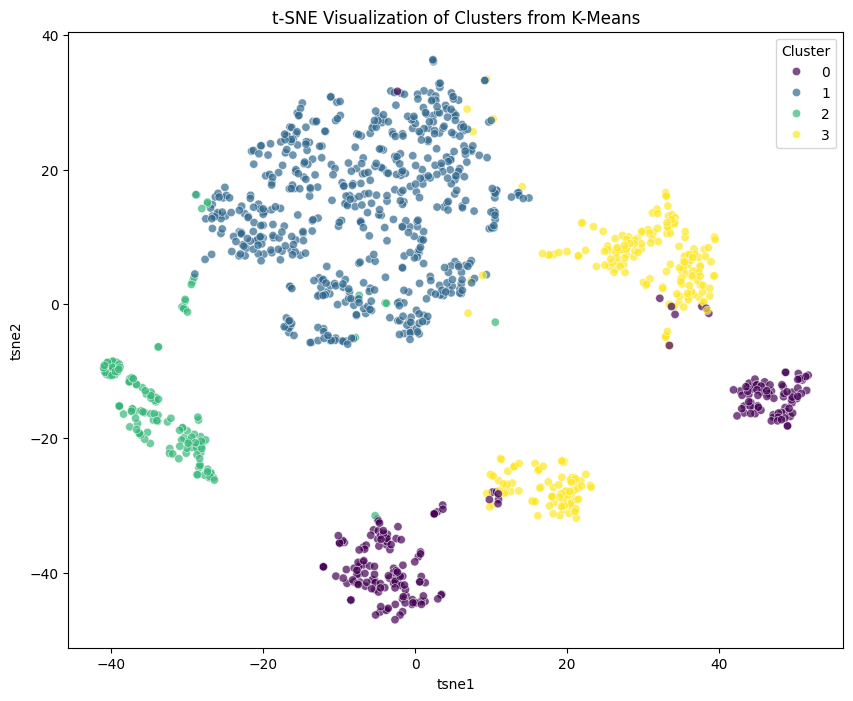

In [21]:
plot_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
plot_df['Cluster'] = results[best_model_name]['Labels']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=plot_df, x='tsne1', y='tsne2', hue='Cluster', palette='viridis', legend='full', alpha=0.7)

plt.title(f"t-SNE Visualization of Clusters from {best_model_name}")
plt.show()

In [22]:
df['Cluster_labels'] = results[best_model_name]['Labels']

df.to_csv("wallet_dataset_clustered.csv", index=False)

In [23]:
cluster_summary = df.groupby('Cluster_labels')[feature_cols].mean()

cluster_counts = df['Cluster_labels'].value_counts().sort_index()
cluster_summary['Wallet_Count'] = cluster_counts

cluster_summary.T

Cluster_labels,0,1,2,3
tx_count,9.443973e+04,1.250151e+02,666.434483,1.108734e+05
active_days,8.412054e+01,2.097822e+01,19.489655,8.507843e+01
avg_tx_per_day,1.177366e+03,3.996650e+00,16.144828,1.265584e+03
total_gas_spent,7.124840e+00,1.598453e-02,0.199650,4.169366e+01
total_nft_buys,1.216764e+04,2.097819e+04,421.958621,1.004119e+05
total_nft_sells,9.206875e+02,4.523295e+04,343.903448,7.886314e+04
total_nft_volume_usd,-3.962041e+02,2.260676e+06,17.721082,5.458021e+05
unique_nfts_owned,4.902094e+03,1.903695e+03,81.537931,7.398847e+03
dex_trades,1.415179e+00,8.677129e+05,12874.744828,3.731336e+06
avg_trade_size_usd,1.640612e+01,9.744801e+02,0.759791,6.922411e+03


In [24]:
key_metrics = ['total_traded_usd', 'tx_count', 'active_days', 'total_nft_volume_usd', 'total_gas_spent']

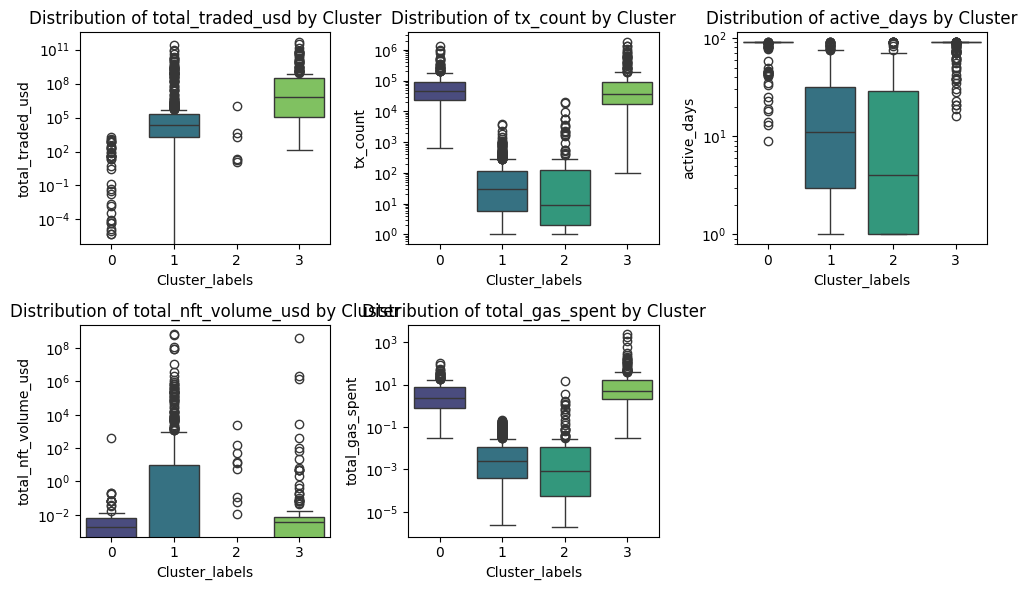

In [25]:
plt.figure(figsize=(10, 6))
for i, metric in enumerate(key_metrics):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Cluster_labels', y=metric, data=df, palette = 'viridis')
    plt.title(f"Distribution of {metric} by Cluster")
    plt.yscale('log')

plt.tight_layout()
plt.show()

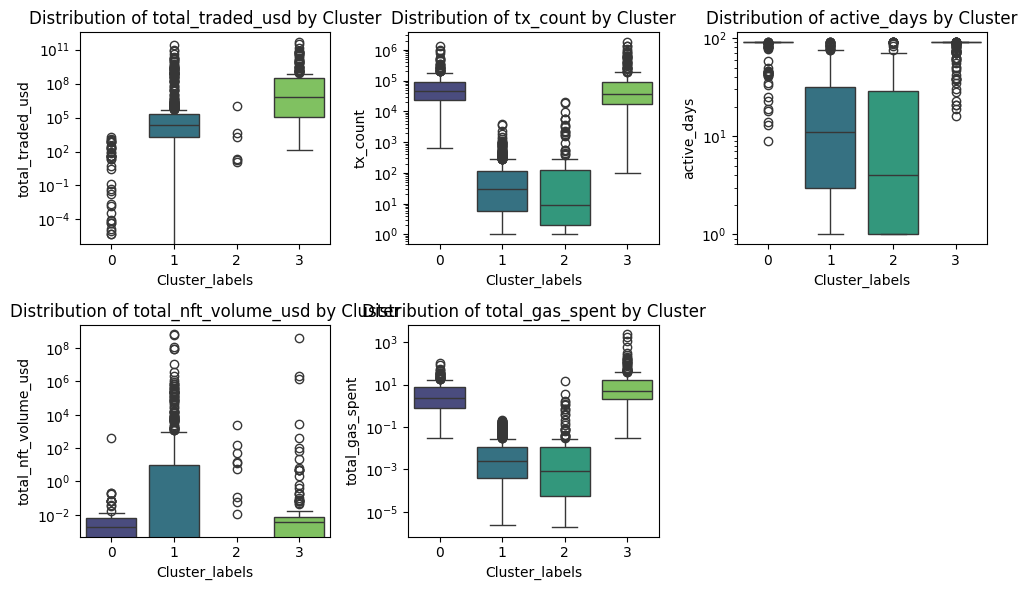

In [26]:
plt.figure(figsize=(10, 6))
for i, metric in enumerate(key_metrics):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Cluster_labels', y=metric, data=df, palette = 'viridis')
    plt.title(f"Distribution of {metric} by Cluster")
    plt.yscale('log')

plt.tight_layout()
plt.show()

In [27]:
snake_df = X_scaled.copy()
snake_df['Cluster'] = df['Cluster_labels']

snake_melt = pd.melt(snake_df.reset_index(drop=True),
                     id_vars=['Cluster'],
                     value_vars= feature_cols,
                     var_name="Metric",
                     value_name= 'Value')

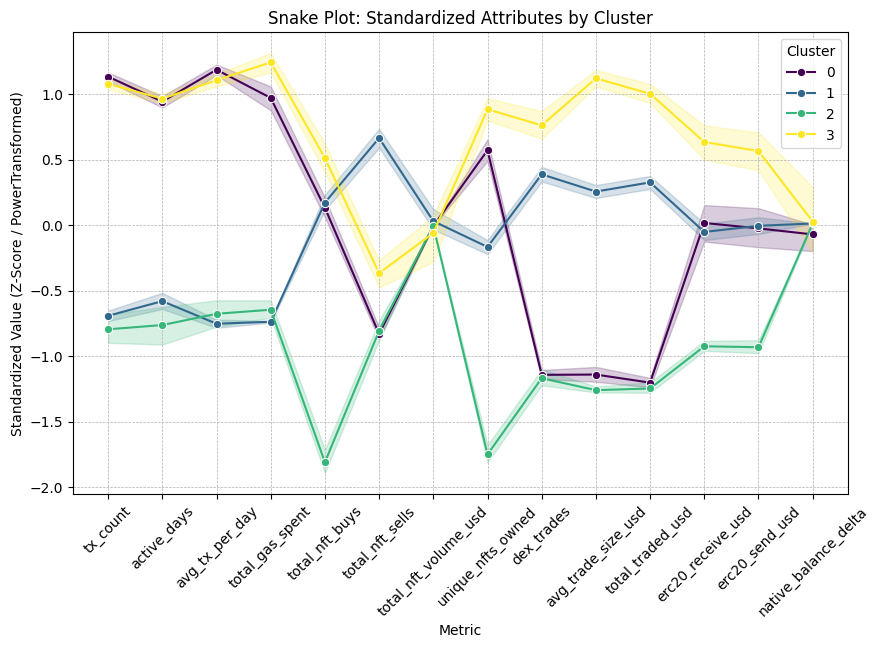

In [28]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=snake_melt, x='Metric', y='Value', hue='Cluster', marker='o', palette='viridis')
plt.title("Snake Plot: Standardized Attributes by Cluster")
plt.xticks(rotation=45)
plt.ylabel('Standardized Value (Z-Score / PowerTransformed)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [29]:
# cluster_names = {
#     0: "High Activity Traders",
#     1: "Occasional NFT Buyers",
#     2: "Low Activity Wallets",
#     3: "Frequent Gas Spenders"
# }

cluster_names = {
    0: "High-Frequency Bots / Automated Traders",
    1: "High-Value NFT & Crypto Traders (Degen Whales)",
    2: "Active Retail Users / Everyday Traders",
    3: "Ultra-Whales / Institutional & Exchange Wallets"
}

df['Persona'] = df['Cluster_labels'].map(cluster_names)

df[["wallet_address", "Cluster_labels", "Persona", "total_traded_usd"]].head()

,wallet_address,Cluster_labels,Persona,total_traded_usd
0,0x000000000000000000000000000000000000dead,3,Ultra-Whales / Institutional & Exchange Wallets,1.048650e+09
1,0x0000000000000792b907283999351c9587689a82,3,Ultra-Whales / Institutional & Exchange Wallets,5.984039e+07
2,0x00000000000124d994209fbb955e0217b5c2eca1,3,Ultra-Whales / Institutional & Exchange Wallets,1.971544e+07
3,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,1,High-Value NFT & Crypto Traders (Degen Whales),1.927236e+10
4,0x000000002a634f97eef66251b538046514d94f4a,3,Ultra-Whales / Institutional & Exchange Wallets,7.616614e+07


In [30]:
df.to_csv("wallet_dataset_labeled.csv", index=False)